# Baseline vs Recurrent Transformer Comparison

This notebook compares two transformer architectures:
1. **Baseline Transformer**: Standard multi-layer architecture
2. **Recurrent Transformer**: Iterates through fewer layers multiple times

Key comparisons:
- Model size and parameter efficiency
- Training dynamics and convergence
- Inference speed vs accuracy trade-offs
- Hyperparameter sensitivity analysis


In [17]:
import sys
import os

# Add parent directory to path for imports
PROJECT_ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, PROJECT_ROOT)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [18]:
# Model configurations
BASELINE_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

RECURRENT_CONFIG = {
    'hidden_size': 256,
    'num_hidden_layers': 3,
    'recurrent_depth': 2,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 4,
    'intermediate_size': 1024,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}


In [19]:
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

DATA_DIR = os.path.join(PROJECT_ROOT, 'data/processed')

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir=DATA_DIR,
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")


Loaded 54576 samples from d:\Projects\DSAN\5800\GU-ANLY-5800\final\5800_FinalProject\data/processed\sst2_train.pkl
Loaded 6822 samples from d:\Projects\DSAN\5800\GU-ANLY-5800\final\5800_FinalProject\data/processed\sst2_val.pkl
Loaded 6823 samples from d:\Projects\DSAN\5800\GU-ANLY-5800\final\5800_FinalProject\data/processed\sst2_test.pkl
Dataset sizes - Train: 54576, Validation: 6832


In [20]:
# Initialize models
from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig

# Baseline model
baseline_config = BaselineConfig(
    vocab_size=30522,
    hidden_size=BASELINE_CONFIG['hidden_size'],
    num_hidden_layers=BASELINE_CONFIG['num_hidden_layers'],
    num_attention_heads=BASELINE_CONFIG['num_attention_heads'],
    intermediate_size=BASELINE_CONFIG['intermediate_size'],
    hidden_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    num_labels=2,
    **{k: v for k, v in BASELINE_CONFIG.items() if k.startswith('use_')}
)

# Recurrent model
recurrent_config = RecurrentConfig(
    vocab_size=30522,
    hidden_size=RECURRENT_CONFIG['hidden_size'],
    num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
    recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
    num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
    intermediate_size=RECURRENT_CONFIG['intermediate_size'],
    hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    residual_scale=RECURRENT_CONFIG['residual_scale'],
    num_labels=2,
    **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
)

baseline_model = BaselineModel(baseline_config).to(device)
recurrent_model = RecurrentModel(recurrent_config).to(device)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

baseline_params = count_parameters(baseline_model)
recurrent_params = count_parameters(recurrent_model)

print(f"Baseline: {baseline_params:,} parameters ({baseline_params/1e6:.1f}M)")
print(f"Recurrent: {recurrent_params:,} parameters ({recurrent_params/1e6:.1f}M)")
print(f"Parameter reduction: {(1 - recurrent_params/baseline_params)*100:.1f}%")


Baseline: 25,912,706 parameters (25.9M)
Recurrent: 10,972,162 parameters (11.0M)
Parameter reduction: 57.7%


In [21]:
# Train both models with early stopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy

def train_model(model, name, num_epochs=TRAINING_CONFIG['num_epochs'], patience=3, min_delta=0.001):
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []
        
        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            
            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                
                val_losses.append(outputs['loss'].item())
                predictions = outputs['logits'].argmax(dim=-1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f} *")
        else:
            patience_counter += 1
            print(f"{name} Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Acc={val_acc:.4f}")
            
        if patience_counter >= patience:
            print(f"{name}: Early stopping triggered at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{name}: Loaded best model with val_loss={best_val_loss:.4f}")
    
    return history

# Train models
print("Training with early stopping (patience=3)")
print("-" * 50)
baseline_history = train_model(baseline_model, "Baseline")
print()
recurrent_history = train_model(recurrent_model, "Recurrent")


Training with early stopping (patience=3)
--------------------------------------------------


Baseline Epoch 1: Train=0.4304, Val=0.2931, Acc=0.8813 *


Baseline Epoch 2: Train=0.2606, Val=0.3224, Acc=0.8956


Baseline Epoch 3: Train=0.2192, Val=0.2819, Acc=0.9068 *


Baseline Epoch 4: Train=0.1900, Val=0.3044, Acc=0.9115


Baseline Epoch 5: Train=0.1657, Val=0.3640, Acc=0.9142
Baseline: Loaded best model with val_loss=0.2819



Recurrent Epoch 1: Train=0.4446, Val=0.2961, Acc=0.8816 *


Recurrent Epoch 2: Train=0.2675, Val=0.2813, Acc=0.8978 *


Recurrent Epoch 3: Train=0.2226, Val=0.2925, Acc=0.9005


Recurrent Epoch 4: Train=0.1989, Val=0.3027, Acc=0.9056


Recurrent Epoch 5: Train=0.1783, Val=0.2969, Acc=0.9099
Recurrent: Early stopping triggered at epoch 5
Recurrent: Loaded best model with val_loss=0.2813


In [22]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()
    
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []
    
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))
            
            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    
    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)
    
    # Calculate F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'inference_time_ms': avg_inference_time
    }

# Evaluate on test set
baseline_metrics = evaluate_model(baseline_model, test_loader)
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
baseline_size_mb = baseline_params * 4 / (1024 * 1024)  # 4 bytes per parameter
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Recurrent'],
    'Parameters': [baseline_params, recurrent_params],
    'Size (MB)': [baseline_size_mb, recurrent_size_mb],
    'Accuracy': [baseline_metrics['accuracy'], recurrent_metrics['accuracy']],
    'F1': [baseline_metrics['f1'], recurrent_metrics['f1']],
    'Precision': [baseline_metrics['precision'], recurrent_metrics['precision']],
    'Recall': [baseline_metrics['recall'], recurrent_metrics['recall']],
    'Inference (ms)': [baseline_metrics['inference_time_ms'], recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0   Baseline    25912706    98.8491    0.9061  0.9153     0.9123  0.9183   
1  Recurrent    10972162    41.8555    0.8974  0.9060     0.9183  0.8940   

   Inference (ms)  
0          0.2090  
1          0.2471  


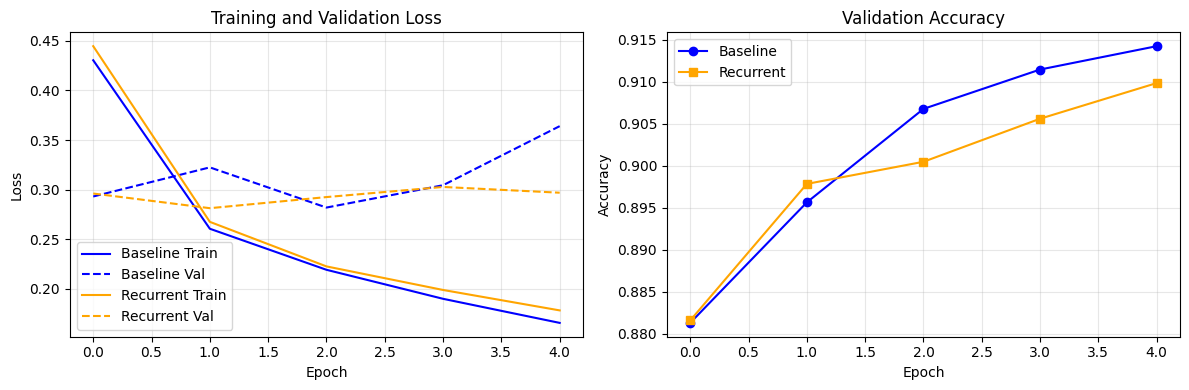

In [23]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(baseline_history['train_loss'], label='Baseline Train', color='blue', linestyle='-')
axes[0].plot(baseline_history['val_loss'], label='Baseline Val', color='blue', linestyle='--')
axes[0].plot(recurrent_history['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
axes[0].plot(recurrent_history['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_history['val_acc'], label='Baseline', color='blue', marker='o')
axes[1].plot(recurrent_history['val_acc'], label='Recurrent', color='orange', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


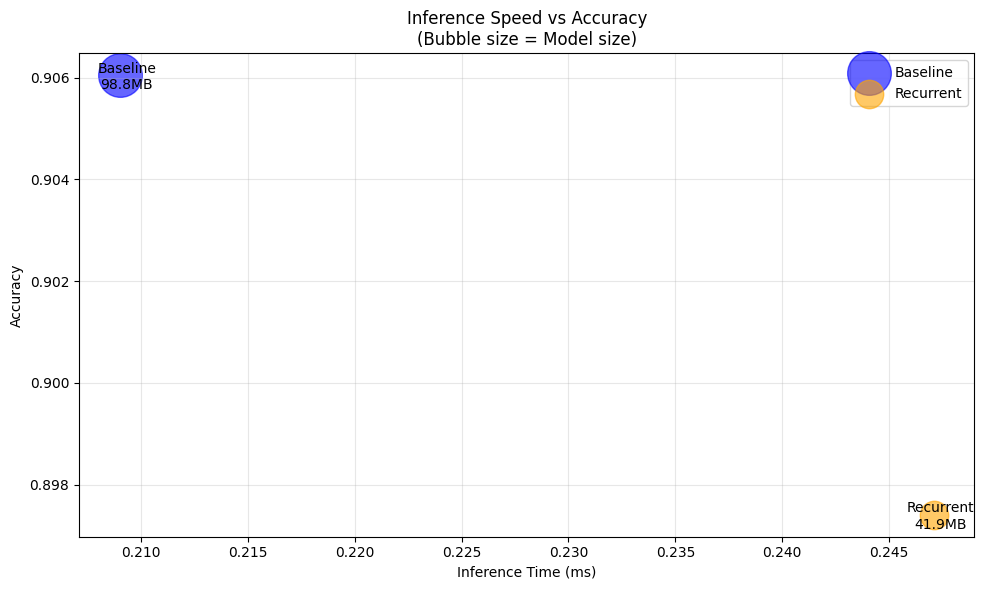

In [24]:
# Bubble plot: Inference Time vs Accuracy
plt.figure(figsize=(10, 6))

# Create bubble sizes based on model size
bubble_sizes = [
    baseline_size_mb * 10,
    recurrent_size_mb * 10
]

# Plot bubbles
plt.scatter([baseline_metrics['inference_time_ms']], [baseline_metrics['accuracy']], 
           s=bubble_sizes[0], alpha=0.6, color='blue', label='Baseline')
plt.scatter([recurrent_metrics['inference_time_ms']], [recurrent_metrics['accuracy']], 
           s=bubble_sizes[1], alpha=0.6, color='orange', label='Recurrent')

# Add annotations
plt.annotate(f'Baseline\n{baseline_size_mb:.1f}MB', 
            xy=(baseline_metrics['inference_time_ms'], baseline_metrics['accuracy']),
            xytext=(5, -10), textcoords='offset points', ha='center')
plt.annotate(f'Recurrent\n{recurrent_size_mb:.1f}MB', 
            xy=(recurrent_metrics['inference_time_ms'], recurrent_metrics['accuracy']),
            xytext=(5, -10), textcoords='offset points', ha='center')

plt.xlabel('Inference Time (ms)')
plt.ylabel('Accuracy')
plt.title('Inference Speed vs Accuracy\n(Bubble size = Model size)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
